# analyze grid experiments

In [21]:
import re

import helpers
import numpy as np
import pandas as pd
import upath

In [22]:
import logging

logger = logging.getLogger(__name__)
handler = logging.StreamHandler()
formatter = logging.Formatter("%(levelname)-8s %(message)s")
handler.setFormatter(formatter)
logger.handlers = [handler]
logger.setLevel("DEBUG")

In [23]:
logger.debug("lol")

DEBUG    lol


In [52]:
path_root = upath.UPath("gs://liulab/differential_composition_and_expression/20230224_07h54m40s")
parquet_paths = path_root.glob("**/deg_analysis/gene_stats_malignant_cibersortx.parquet")
parquet_paths = map(str, parquet_paths)
parquet_paths = filter(re.compile(r'.*run_id=0[0-2].*').match, parquet_paths)
parquet_paths = sorted(parquet_paths)
parquet_paths = list(parquet_paths)

In [53]:
def extract_from_path(path: str, var_name: str) -> str:
    _ = path.split(var_name + "=")[1]
    return _.split("/")[0]


def load_gene_stats_malignant_cibersortx(parquet_paths: list[str]):
    df = pd.concat(
        {str(path): pd.read_parquet(path) for path in parquet_paths},
        names=["path", "index"],
    )
    orderings = {
        "malignant_means": ["0.71,0.71", "0.7,0.72", "0.65,0.75", "0.6,0.8", "0.55,0.85"],
        "log2_fc": ["-1.50", "-1.00", "-0.50", "-0.25", "0.00", "0.25", "0.50", "1.00", "1.50"],
    }
    for column_name in ["malignant_means", "log2_fc", "run_id"]:
        s = df.index.get_level_values("path").map(lambda path: extract_from_path(path, column_name))
        if column_name in orderings:
            logger.debug(f"Setting ordering for {column_name}")
            s = s.astype(pd.CategoricalDtype(orderings[column_name], ordered=True))
        df[column_name] = s
    
    # add gene_perturbed column
    genes_perturbed = pd.read_csv(path_root / "genes_perturbed.csv", index_col=0)
    df["gene_perturbed"] = df["gene_symbol"].isin(genes_perturbed.index)

    df = df.set_index(["malignant_means", "log2_fc", "run_id", "gene_symbol", "gene_perturbed"])
    df = df.sort_index()
    return df

In [54]:
gene_stats_malignant_cibersortx = load_gene_stats_malignant_cibersortx(parquet_paths)
gene_stats_malignant_cibersortx

DEBUG    Setting ordering for malignant_means
DEBUG    Setting ordering for log2_fc


pval  \
malignant_means log2_fc run_id gene_symbol gene_perturbed             
0.71,0.71       -1.50   00     A1BG        False           0.433951   
                               A2M         False           0.882171   
                               A2ML1       False           0.332754   
                               A4GALT      False           1.000000   
                               A4GNT       False           1.000000   
...                                                             ...   
0.55,0.85       1.50    02     ZYG11A      False           0.086692   
                               ZYG11B      False           0.116801   
                               ZYX         False           0.011978   
                               ZZEF1       False           0.025737   
                               ZZZ3        False           0.636765   

                                                           fold_change  \
malignant_means log2_fc run_id gene_symbol gene_perturbed                
0.71,0.71       -1.50   00     A1BG        False              0.896219   
                               A2M         False              1.029666   
                               A2ML1       False              1.137485   
                               A4GALT      False              1.000000   
                               A4GNT       False              1.000000   
...                                                                ...   
0.55,0.85       1.50    02     ZYG11A      False              0.852769   
                               ZYG11B      False              0.860405   
                               ZYX         False              0.763111   
                               ZZEF1       False              0.744544   
                               ZZZ3        False              1.021537   

                                                           sparsity_overall  \
malignant_means log2_fc run_id gene_symbol gene_perturbed                     
0.71,0.71       -1.50   00     A1BG        False                        0.0   
                               A2M         False                        0.0   
                               A2ML1       False                        0.0   
                               A4GALT      False                        0.0   
                               A4GNT       False                        0.0   
...                                                                     ...   
0.55,0.85       1.50    02     ZYG11A      False                        0.0   
                               ZYG11B      False                        0.0   
                               ZYX         False                        0.0   
                               ZZEF1       False                        0.0   
                               ZZZ3        False                        0.0   

                                                           -log10_pval  \
malignant_means log2_fc run_id gene_symbol gene_perturbed                
0.71,0.71       -1.50   00     A1BG        False              0.362559   
                               A2M         False              0.054447   
                               A2ML1       False              0.477877   
                               A4GALT      False             -0.000000   
                               A4GNT       False             -0.000000   
...                                                                ...   
0.55,0.85       1.50    02     ZYG11A      False              1.062023   
                               ZYG11B      False              0.932554   
                               ZYX         False              1.921623   
                               ZZEF1       False              1.589435   
                               ZZZ3        False              0.196021   

                                                           log2_fold_change  \
malignant_means log2_fc run_id gene_symbol gene_perturbed                     
0.71,0.71       -1.50   00 

In [55]:
gene_stats_malignant_cibersortx.groupby(["malignant_means", "log2_fc", "run_id", "gene_perturbed"]).size().unstack("log2_fc")

log2_fc                                -1.50  -1.00  -0.50  -0.25   0.00  \
malignant_means run_id gene_perturbed                                      
0.71,0.71       00     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                01     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                02     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
0.7,0.72        00     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                01     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                02     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
0.65,0.75       00     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                01     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                02     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
0.6,0.8         00     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                01     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                02     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
0.55,0.85       00     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                01     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   
                02     False           15963  15963  15963  15963  15963   
                       True              100    100    100    100    100   

log2_fc                                 0.25   0.50   1.00   1.50  
malignant_means run_id gene_perturbed                              
0.71,0.71       00     False           15963  15963  15963  15963  
                       True              100    100    100    100  
                01     False           15963  15963  15963  15963  
                       True              100    100    100    100  
                02     False           15963  15963  15963  15963  
                       True              100    100    100    100  
0.7,0.72        00     False           15963  15963  15963  15963  
                       True              100    100    100    100  
                01     False           15963  15963  15963  15963  
                       True              100    100    100    100  
                02     False           15963  15963  15963  15963  
                       True              100    100    100    100  
0.65,0.75       00     False           15963  15963  15963  15963  
                       True              100    100    100    100  
                01     False           15963  15963  15963  15963  
                       True              100    100    100    100  
                02     False           15963  15963  15963  15963  
                       True              100    100    100    100  
0.6,0.8         00     False           15963  15963  15963  15963  
                       True              100    100    100    100  
                01     False           15963  15963  15963  15963  
   

In [56]:
import plotly.express as px

In [57]:
def make_fig(df):
    df = df.groupby(["malignant_means", "log2_fc", "gene_symbol", "gene_perturbed"])[["log2_fold_change", "-log10_pval", "significant_bh_fdr=0.10"]].mean()
    # df = df.sort_index(ascending=[True, True, False])
    df = df.reset_index()
    fig = px.scatter(
        df,
        x="log2_fold_change",
        y="-log10_pval",
        facet_col="malignant_means",
        facet_row="log2_fc",
        # hover_name="gene_symbol",
        color="gene_perturbed",
    )
    # set marker size to 1
    fig.update_traces(marker_size=1)
    fig.update_xaxes(range=[-2, 2])
    fig.update_yaxes(range=[0, 6])
    return fig


fig = make_fig(gene_stats_malignant_cibersortx)

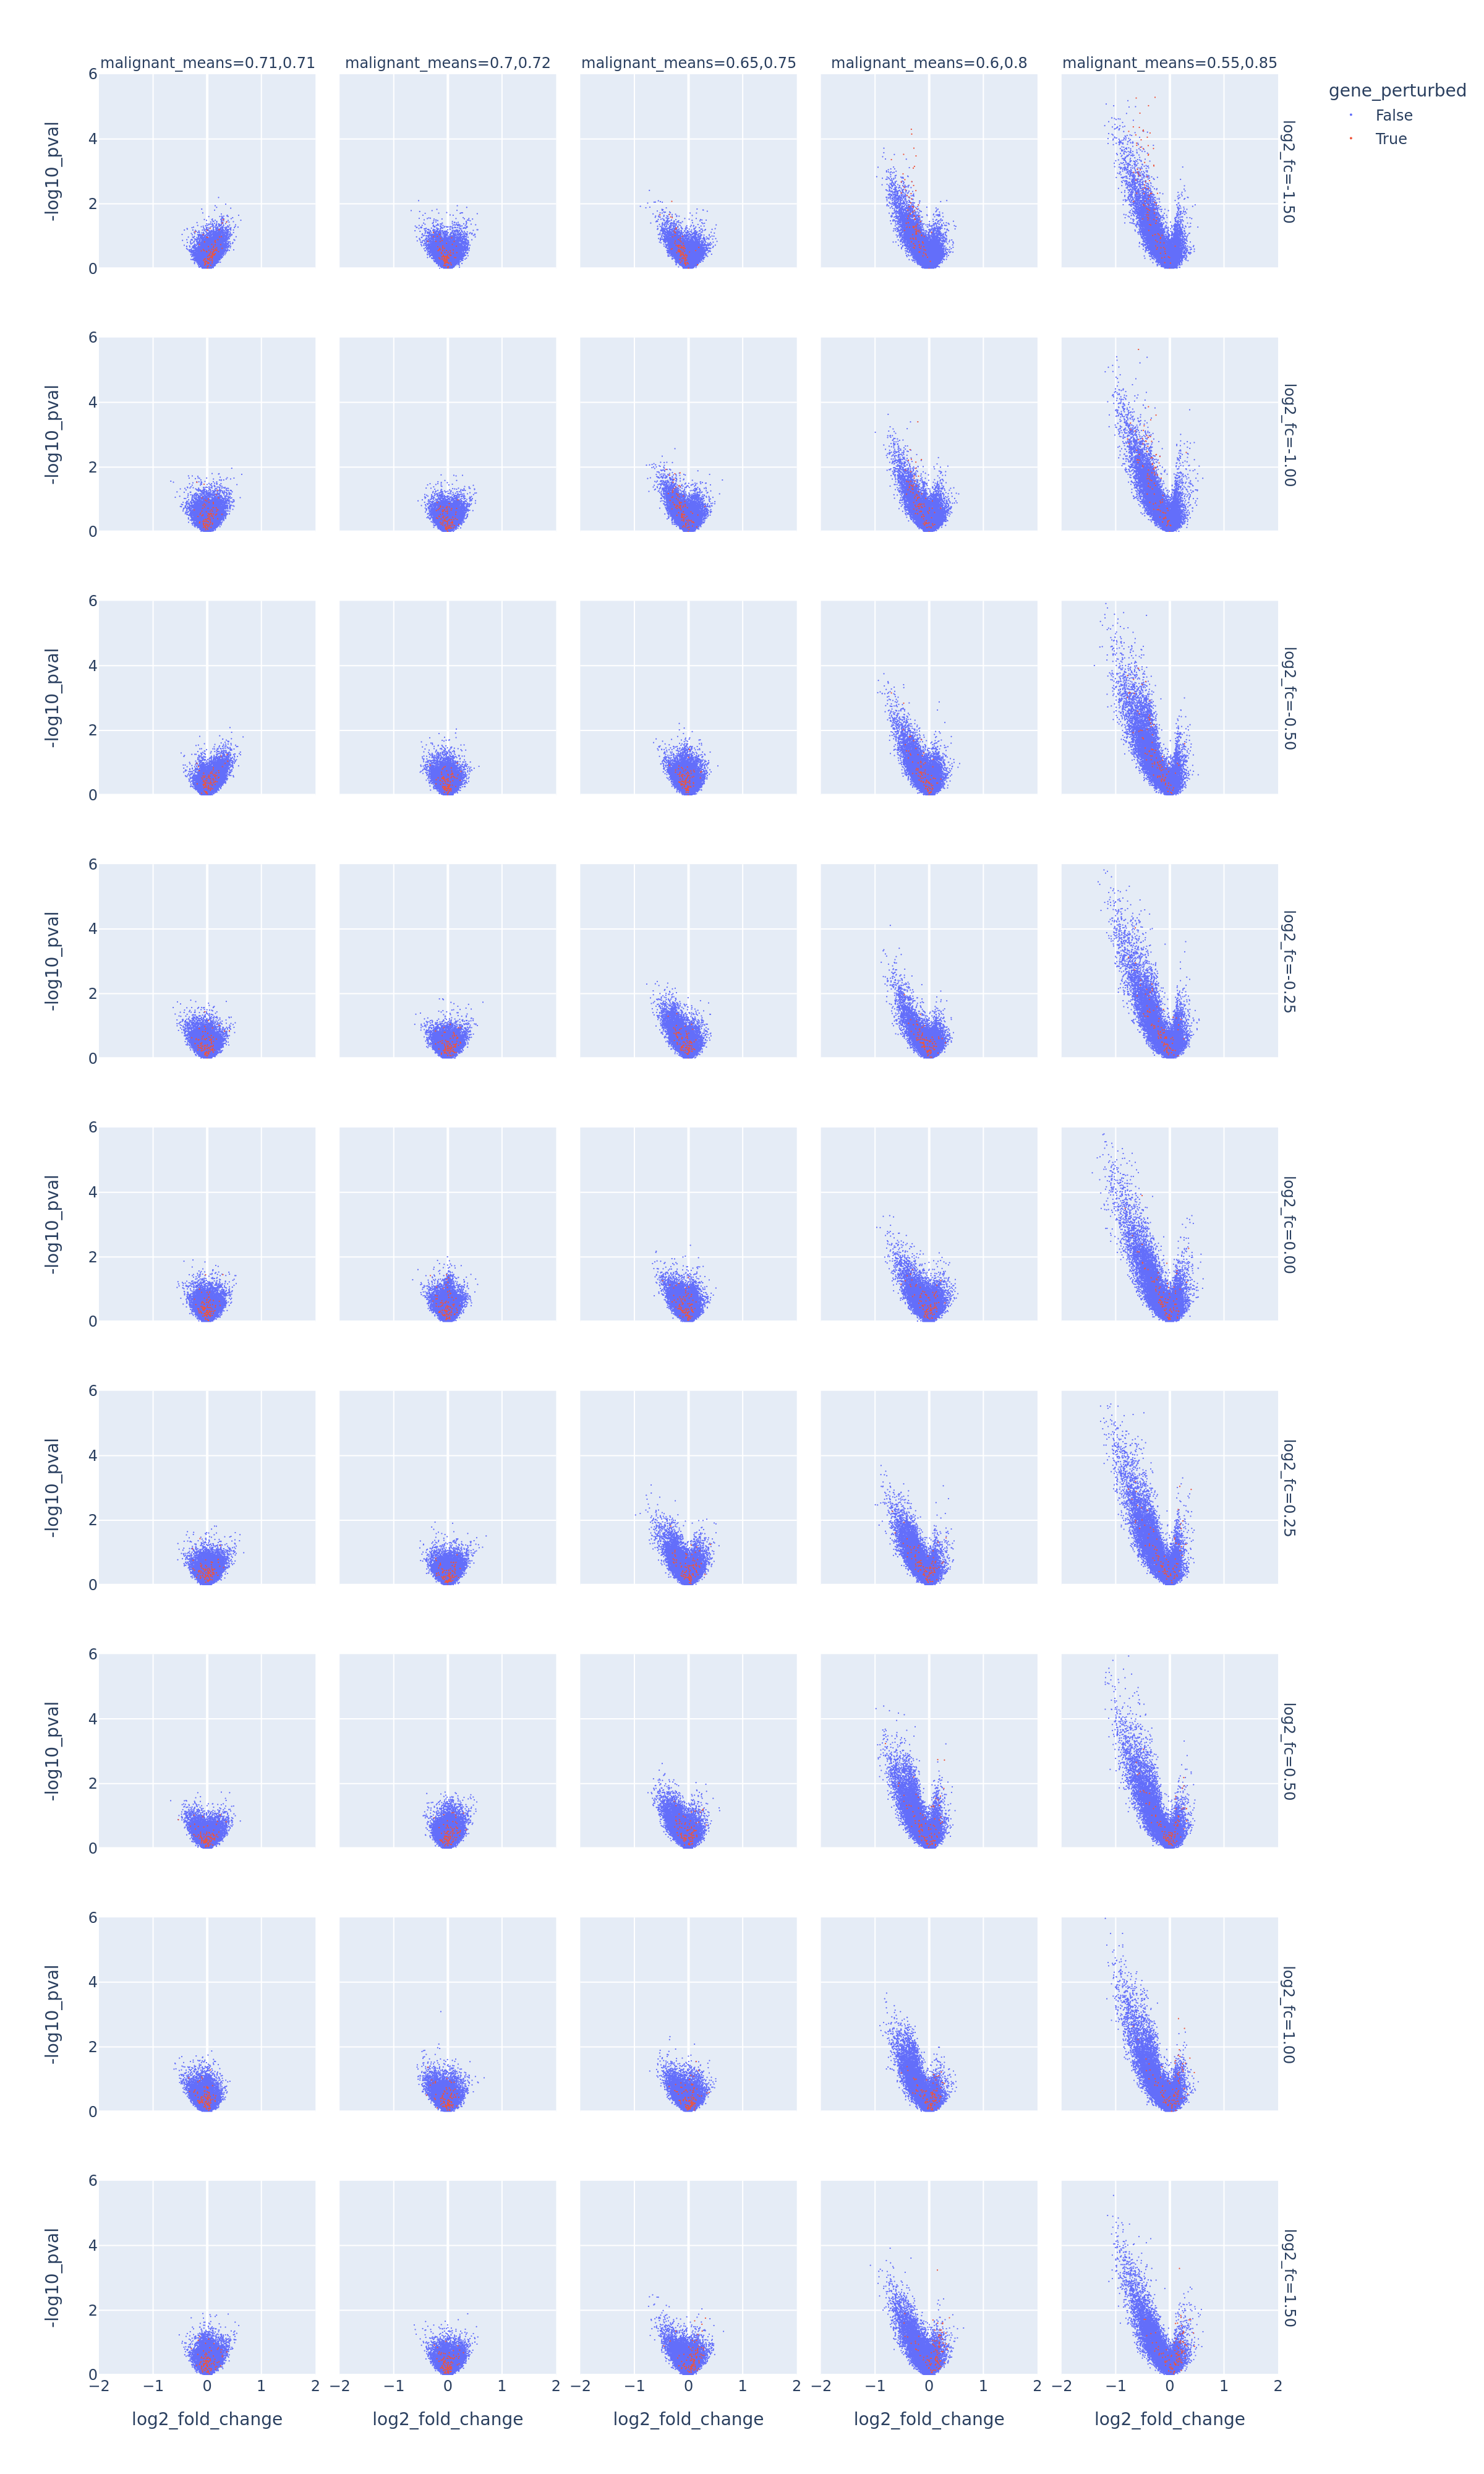

In [58]:
fig.update_layout(width=1200, height=2000)
fig.show(renderer="png", scale=2)

In [ ]:
def make_fig(df):
    df = df.groupby(["malignant_means", "log2_fc", "gene_symbol", "gene_perturbed"])[["log2_fold_change", "-log10_pval", "significant_bh_fdr=0.10"]].mean()
    # df = df.sort_index(ascending=[True, True, False])
    df = df.reset_index()
    fig = px.density_contour(
        df,
        x="log2_fold_change",
        y="-log10_pval",
        facet_col="malignant_means",
        facet_row="log2_fc",
        # hover_name="gene_symbol",
        # color="gene_perturbed",
    )
    # set marker size to 1
    # fig.update_traces(marker_size=1)
    # fig.update_xaxes(range=[-2, 2])
    # fig.update_yaxes(range=[0, 6])
    return fig


fig = make_fig(gene_stats_malignant_cibersortx)

: 

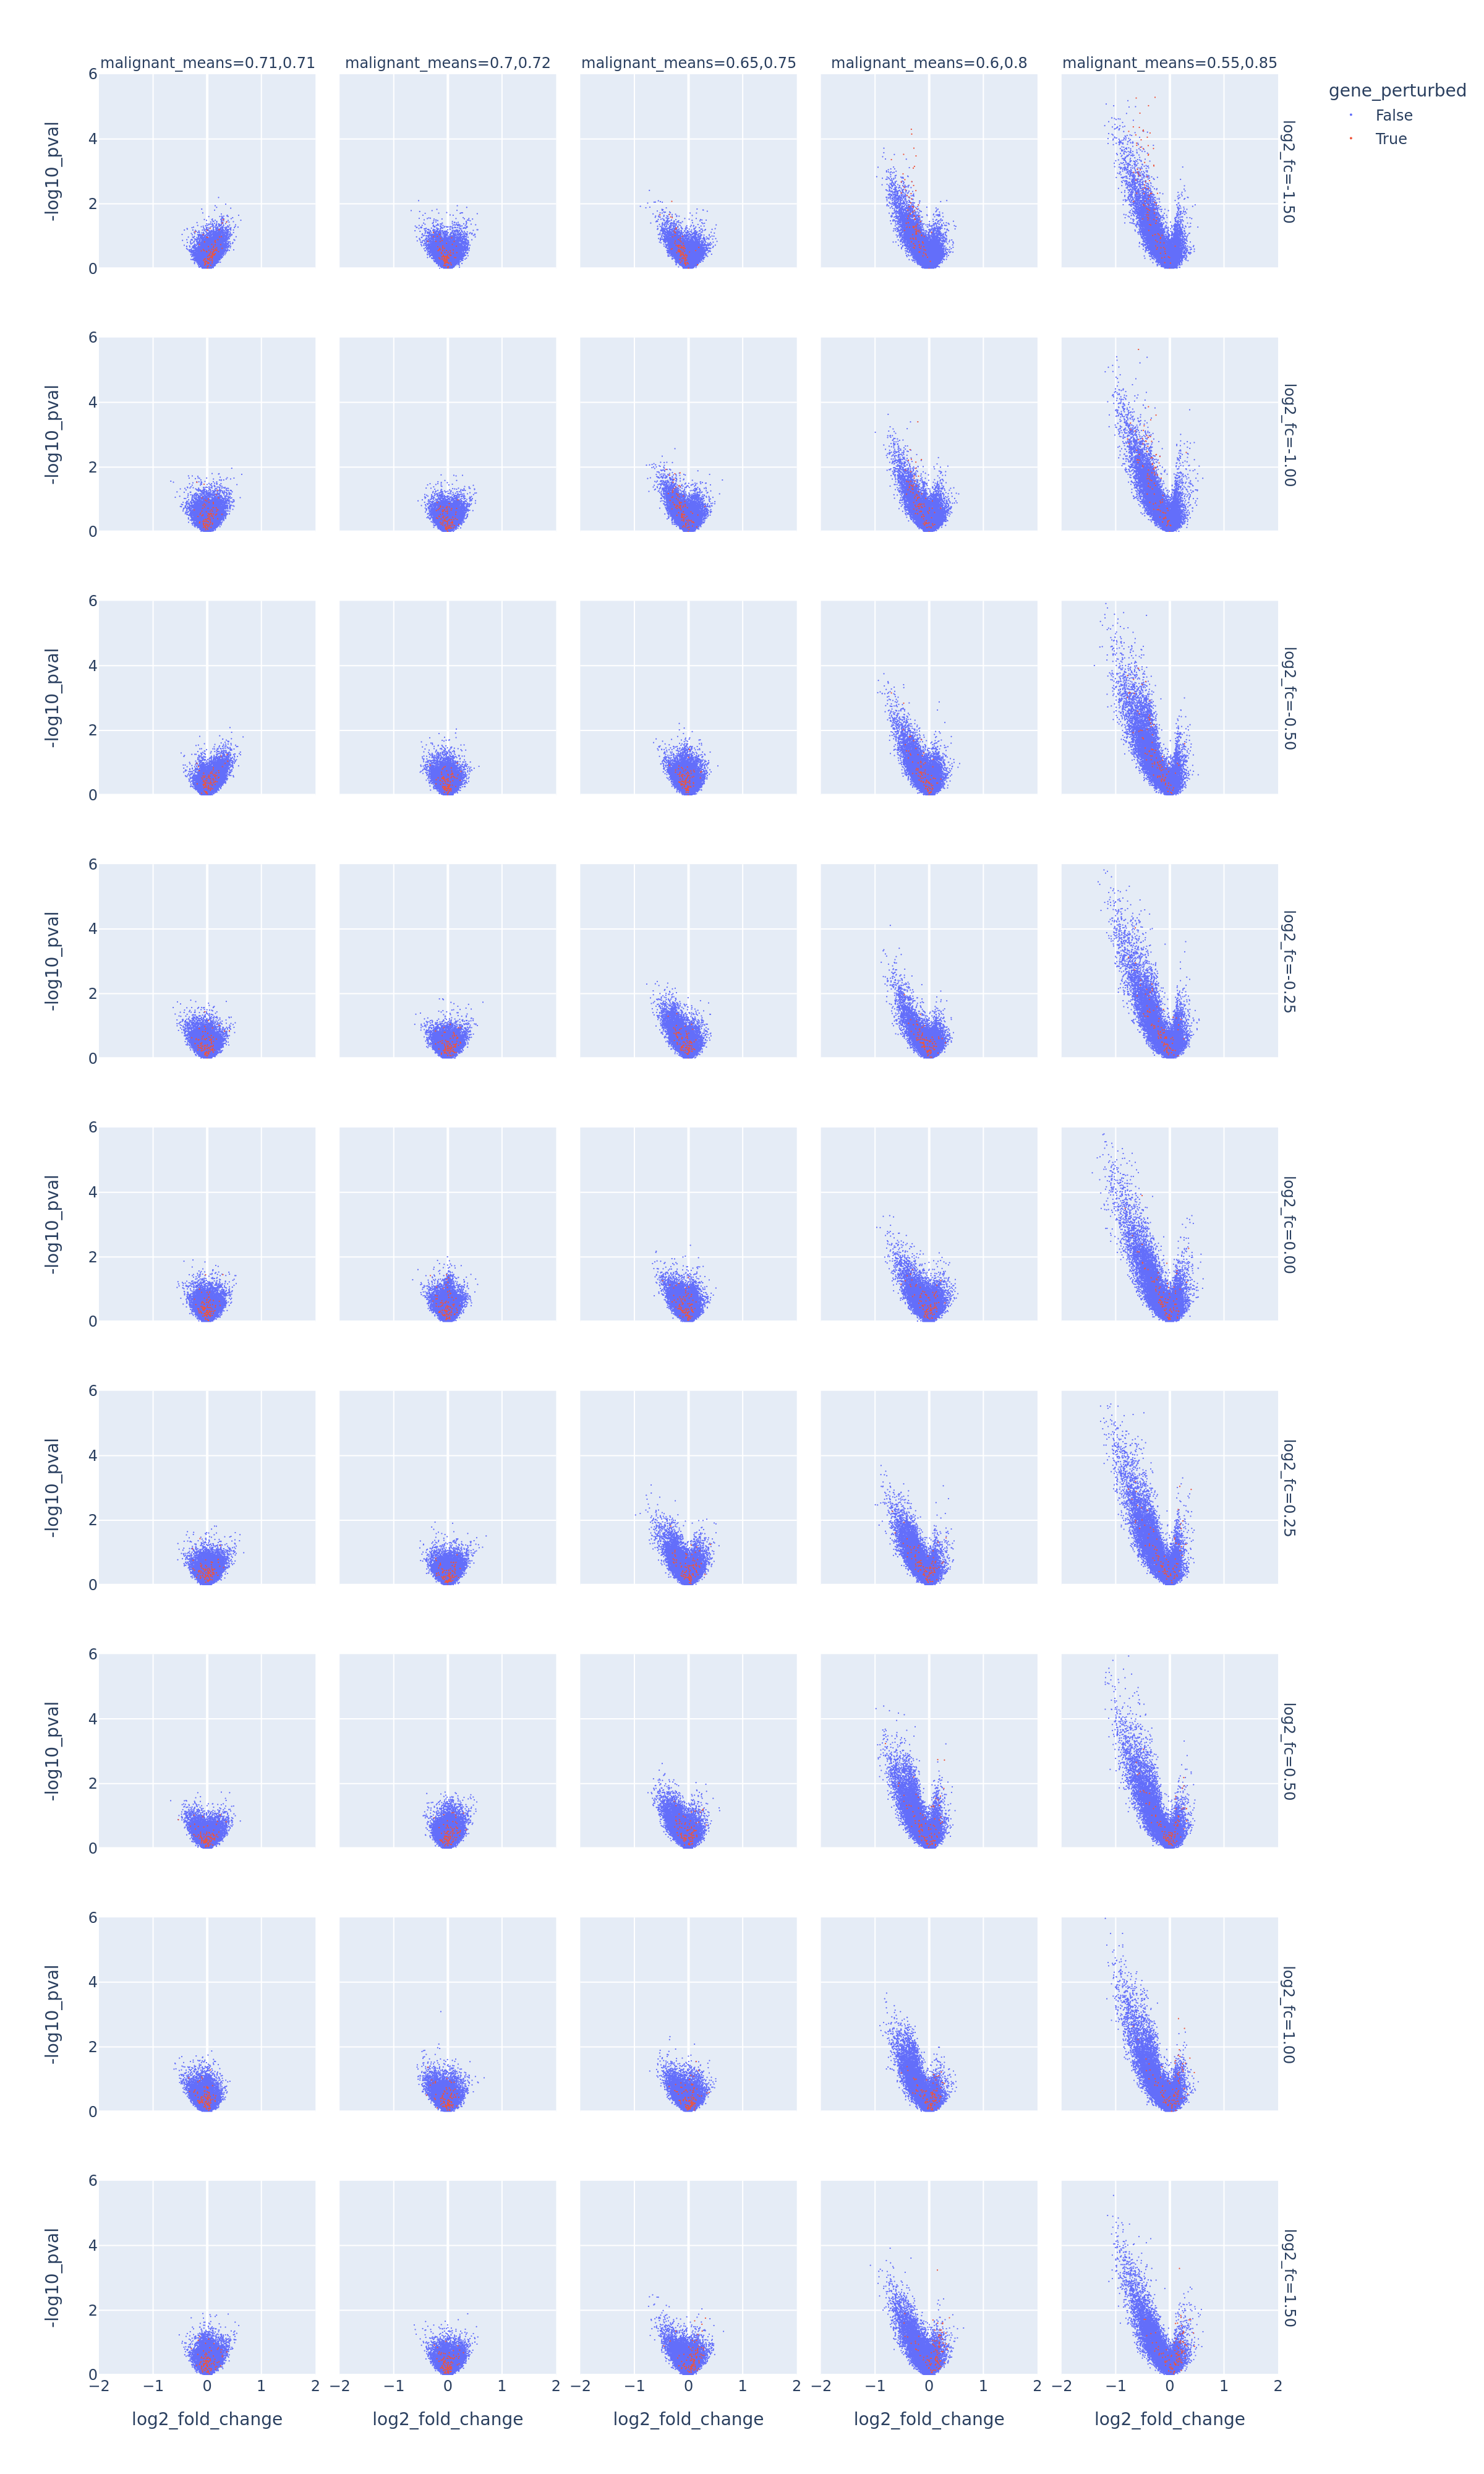

In [ ]:
fig.update_layout(width=1200, height=2000)
fig.show(renderer="png", scale=1)